In [1]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
import keras
from keras import layers, metrics

import matplotlib.pyplot as plt; plt.style.use('dark_background')
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
pd.options.display.max_rows = 10

import os
import numpy as np
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.table import Table



from datetime import datetime
import pickle

import warnings; warnings.simplefilter("ignore")

#

TensorFlow version: 2.15.0


In [2]:
def format_lc(data, times, magnitude="mag_opt"):
    '''
    Format a BlackGEM lightcurve for the RNN model

    Splits data by filter (q, i) and MJD (60290, 60291)
    For each combination, normalize to mean=0 stddev=1 (four combinations: q-60290, i-60290, q-60291, i-60291)
    Interpolate each onto the same time grid (one grid per filter)
    Combine the data and sort by MJD

    Inputs:
        times: list of lists [times_q, times_i]
         data: Pandas DataFrame containing the lightcurve data with columns ["MJD", "MAG_OPT", "FILTER"]

    Outputs:
        lc: 1D list of normalized magnitude values
    '''

    # Normalize day1 data:
    data.loc[(data["filter"]=="q") & (data["mjd"]<60291), magnitude] -= np.mean(data[(data["filter"]=="q") & (data["mjd"]<60291)][magnitude].values)
    data.loc[(data["filter"]=="i") & (data["mjd"]<60291), magnitude] -= np.mean(data[(data["filter"]=="i") & (data["mjd"]<60291)][magnitude].values)

    data.loc[(data["filter"]=="q") & (data["mjd"]<60291), magnitude] /= np.std(data[(data["filter"]=="q") & (data["mjd"]<60291)][magnitude].values)
    data.loc[(data["filter"]=="i") & (data["mjd"]<60291), magnitude] /= np.std(data[(data["filter"]=="i") & (data["mjd"]<60291)][magnitude].values)


    # Normalize day2 data:
    data.loc[(data["filter"]=="q") & (data["mjd"]>60291), magnitude] -= np.mean(data[(data["filter"]=="q") & (data["mjd"]>60291)][magnitude].values)
    data.loc[(data["filter"]=="i") & (data["mjd"]>60291), magnitude] -= np.mean(data[(data["filter"]=="i") & (data["mjd"]>60291)][magnitude].values)

    data.loc[(data["filter"]=="q") & (data["mjd"]>60291), magnitude] /= np.std(data[(data["filter"]=="q") & (data["mjd"]>60291)][magnitude].values)
    data.loc[(data["filter"]=="i") & (data["mjd"]>60291), magnitude] /= np.std(data[(data["filter"]=="i") & (data["mjd"]>60291)][magnitude].values)

    
    qdata = data[data["filter"]=="q"]
    idata = data[data["filter"]=="i"]

    times_q, times_i = times
    
    new_qmag = interp1d(qdata["mjd"].values, qdata[magnitude].values, bounds_error=False, fill_value=0)(times_q)
    new_qdata = pd.DataFrame({"mjd":times_q, magnitude:new_qmag})

    
    new_imag = interp1d(idata["mjd"].values, idata[magnitude].values, bounds_error=False, fill_value=0)(times_i)
    new_idata = pd.DataFrame({"mjd":times_i, magnitude:new_imag})

    new_data = pd.concat([new_qdata, new_idata]).sort_values(by="mjd")

    return(list(new_data[magnitude].values))

#

In [3]:
def plot_ccd(predictions_df, image_file, scale, galactic=False, ):
    '''
    Overplot colored regions on one CCD image for the field.
    Colorbar based on the provided label 
        Colors:(red -> yellow -> blue) for labels:(1.0 -> 0.5 -> 0.0) using the "turbo" colormap

    Inputs:
    predictions_df: Pandas DataFrame containing columns for at least ["source_id", "label", "X_POS", "Y_POS"]
        image_file: FITS file containing CCD image data to be plotted.
             scale: Inner-quantile range. Used to scale the output plot by its values.
          galactic: Boolean for enabling the Galactic coordinate grid using the WCS values in the header
    Outputs:
        None
    '''

    fits_file = fits.open(image_file)[1]
    image_data = fits_file.data

    upper = np.percentile(image_data, 50 + scale/2) # Used for imshow(..., vmax=upper)
    lower = np.percentile(image_data, 50 - scale/2)

    fig = plt.figure(figsize=(10,10))
    fig.tight_layout()
    
    if galactic:
        from astropy.wcs import WCS
        from astropy.utils.data import get_pkg_data_filename
        from astropy.visualization.wcsaxes import WCSAxes

        filename = get_pkg_data_filename(image_file)
    
        wcs = WCS(fits_file.header)
        ax = fig.add_subplot(111, projection=wcs)

        lat_lon = wcs.pixel_to_world(predictions_df["X_POS"].values-1, predictions_df["Y_POS"].values-1) # Galactic latitude and longitude

        ax.imshow(image_data, vmin=lower, vmax=upper, cmap="binary_r", origin="lower")
        ax.scatter(lat_lon.ra, lat_lon.dec, c=predictions_df["label"], cmap="turbo", fc='None', marker='.', linewidths=0.5, s=5, edgecolors=plt.cm.turbo(predictions_df["label"]), transform=ax.get_transform('fk5'))

        # ax.coords.grid(True, color='white', ls='solid')
        ax.coords[0].set_axislabel('Galactic Longitude')
        ax.coords[1].set_axislabel('Galactic Latitude')
    
        overlay = ax.get_coords_overlay('galactic')
        overlay.grid(color='white', ls='dashed', linewidth=1)
        overlay[0].set_axislabel(r'Galactic Longitude ($l$)')
        overlay[1].set_axislabel(r'Galactic Latitude ($b$)')
    
    else:
        ax = fig.add_subplot(111)
        ax.imshow(image_data, vmin=lower, vmax=upper, cmap="binary_r", origin="lower")
        ax.scatter(predictions_df["X_POS"]-1, predictions_df["Y_POS"]-1, c=predictions_df["label"], cmap="turbo", marker='.', linewidths=0.5, s=15, fc='None', edgecolors=plt.cm.turbo(predictions_df["label"]))
    
    
    ax.set_title("Field 3931", loc="left")
    # plt.savefig("RNN_3931.png", dpi=100)
    plt.show()

#

In [4]:
# Read in the full light curve data file, obtained from PySpark code.
# [mjd, quality, filter, source_id, mag_opt, magerr_opt, mag_066, magerr_066, mag_150, magerr_150, mag_500, magerr_500]

lc_df = pd.read_csv("field3931_results.csv") 
lc_df = lc_df[(lc_df["mjd"] < 60292) & (lc_df["mjd"] > 60290)]

#

In [5]:
# Read in the catalog FITS file containing object source_id and pixel positions for the associated field image.
# This file will be used to overplot model predictions on the CCD image later.
catalog_file = "BG4_20231213_060852_red_cat.fits"
catalog_header = fits.open(catalog_file)[1].header
catalog_df = Table.read(catalog_file, format="fits", memmap=True).to_pandas()
print(f"Catalog: {catalog_file}\n  Field = {catalog_header['object']}\n  Filter = {catalog_header['filter']}\n  Quality = {catalog_header['QC-FLAG']}")


# Read in the CCD image data itself.
# Be sure to use the appropriate image data file to match the catalog file since the catalog's X_POS and Y_POS are for one specific image.
image_file = "BG4_20231213_060852_red.fits.fz"
image_header = fits.open(image_file)[1].header
print(f"Image: {image_file}\n  Field = {image_header['object']}\n  Filter = {image_header['filter']}\n  Quality = {image_header['QC-FLAG']}")


#

Catalog: BG4_20231213_060852_red_cat.fits
  Field = 03931
  Filter = q
  Quality = green
Image: BG4_20231213_060852_red.fits.fz
  Field = 03931
  Filter = q
  Quality = green


In [6]:
# Read in the manually-classified source_id and labels from the "phot_g_mean_mag<19" sample
# Create dataframes for the "good" and "bad" light curves separately.
# Combine them into a single dataframe and shuffle it.


bad_ids2 = list(pd.read_csv("classification/p2/bad_ids2.csv", usecols=["source_id"])["source_id"].values)
good_ids2 = list(pd.read_csv("classification/p2/good_ids2.csv", usecols=["source_id"])["source_id"].values)

df_bad2 = catalog_df[(catalog_df["SOURCE_ID"].isin(bad_ids2))][["SOURCE_ID", "X_POS", "Y_POS"]]
df_bad2.insert(3, "label", 1)

df_good2 = catalog_df[(catalog_df["SOURCE_ID"].isin(good_ids2))][["SOURCE_ID", "X_POS", "Y_POS"]]
df_good2.insert(3, "label", 0)


# Create one single dataframe with labels, source_ID, and CCD positions, shuffled with the ".sample(frac=1.0)" method.
label_df2 = pd.concat([df_good2, df_bad2], ignore_index=True).sample(frac=1.0, ignore_index=True)

print(label_df2)
print()
print(f" Bad light curves: {len(bad_ids2)} ({len(label_df2[label_df2['label']==1])} used)")
print(f"Good light curves: {len(good_ids2)} ({len(label_df2[label_df2['label']==0])} used)")

#

                SOURCE_ID     X_POS     Y_POS  label
0     5595806276002920192 7786.5244 5208.7314      0
1     5594277675652014464 5075.7915  339.2028      0
2     5594314303137012736 7536.8701 2567.4006      0
3     5546160096187311488 1322.0687 7671.4424      1
4     5595793661667527552 6371.7681 4891.7690      0
...                   ...       ...       ...    ...
8889  5546159202837105536 1044.1740 7879.3687      0
8890  5546170335392740352 1091.7703 5329.1299      0
8891  5546159683873410816 1333.3777 7962.6816      0
8892  5546167273067267968  917.5752 5315.5967      0
8893  5547700443263203072 4317.1714 9918.0410      0

[8894 rows x 4 columns]

 Bad light curves: 1845 (1844 used)
Good light curves: 7051 (7050 used)


In [7]:
# Read in the manually-classified source_id and labels from the "all objects" sample.
# Filter by "phot_g_mean_mag<19" to match the previous sample.
# Create dataframes for the "good" and "bad" light curves separately.
# Combine them into a single dataframe and shuffle it.



# Read in DataFrame which contains Gaia DR3 match info, such as phot_g_mean_mag and # of neighbors within radius.
# I use this file to filter this sample for "phot_g_mean_mag<19"
df_crowding = pd.read_csv("field3931_crowding.csv") # Results from PySpark search for neighbors

bad_ids1 = list(pd.read_csv("classification/p1/bad_ids1.csv", usecols=["source_id"])["source_id"].values)
good_ids1 = list(pd.read_csv("classification/p1/good_ids1.csv", usecols=["source_id"])["source_id"].values)

df_bad10 = df_crowding[(df_crowding["source_id"].isin(bad_ids1)) & (df_crowding["phot_g_mean_mag"]<19)][["source_id"]]
df_bad1 = catalog_df[(catalog_df["SOURCE_ID"].isin(list(df_bad10["source_id"].values)))][["SOURCE_ID", "X_POS", "Y_POS"]]
df_bad1.insert(3, "label", 1)

df_good10 = df_crowding[(df_crowding["source_id"].isin(good_ids1)) & (df_crowding["phot_g_mean_mag"]<19)][["source_id"]]
df_good1 = catalog_df[(catalog_df["SOURCE_ID"].isin(list(df_good10["source_id"].values)))][["SOURCE_ID", "X_POS", "Y_POS"]]
df_good1.insert(3, "label", 0)

del df_bad10, df_good10


label_df1 = pd.concat([df_good1, df_bad1], ignore_index=True).sample(frac=1.0, ignore_index=True)

print(label_df1)
print()
print(f" Bad light curves: {len(bad_ids1)} ({len(label_df1[label_df1['label']==1])} used)")
print(f"Good light curves: {len(good_ids1)} ({len(label_df1[label_df1['label']==0])} used)")

#

                SOURCE_ID      X_POS      Y_POS  label
0     5595871761352288256 10003.0518 10444.3154      1
1     5595842078852268672 10361.8203  7366.2681      0
2     5595817649076526464  8464.9111  3846.1372      1
3     5595805343980481664  8099.9810  5575.7505      0
4     5595786931469179264  9022.1836  9055.8750      0
...                   ...        ...        ...    ...
5680  5595871731303872256  9989.0957 10370.5195      1
5681  5595799713293098240  7199.0293  4578.7358      0
5682  5595851252894488192 10177.9033  4703.8442      0
5683  5595820805864059776  8685.4004  4384.0376      0
5684  5595868295334054912  9004.6016 10043.6787      0

[5685 rows x 4 columns]

 Bad light curves: 2192 (1421 used)
Good light curves: 7235 (4264 used)


In [8]:
# Combine the two samples into one DataFrame and shuffle again.
# There will be some overlap, so only keep data for duplicates if they have matching labels (both classified as "bad" or both "good")


# Merge the two into a single df_label DataFrame
label_df00 = pd.concat([label_df2, label_df1], ignore_index=True).groupby(["SOURCE_ID"], as_index=False).median()

# Keep only entries where both manual classifications matched (the median-combined label is 0 or 1)
label_df0 = label_df00[label_df00["label"].isin([0,1])]


# Split the data into "good" and "bad" DataFrame
df_good = label_df0[label_df0["label"]==0]
df_bad = label_df0[label_df0["label"]==1]

# Recombine the good and bad into a single dataframe, but down-sample the "good" to match the "bad" for a 50%/50% split on good/bad.
label_df = pd.concat([df_good.sample(len(df_bad), ignore_index=True), df_bad], ignore_index=True).sample(frac=1.0, ignore_index=True)

print(label_df)
print()
print(f" Bad light curves: {len(df_bad):>5d} ({len(label_df[label_df['label']==1]):>5d} used)")
print(f"Good light curves: {len(df_good):>5d} ({len(label_df[label_df['label']==0]):>5d} used)")

#

                SOURCE_ID     X_POS     Y_POS  label
0     5546158889291111680  888.0013 7904.6167 0.0000
1     5594247099785260544 2065.7397 1189.5408 1.0000
2     5595827750839125120 9992.6875 4663.1934 1.0000
3     5546155973017393536  885.3669 6197.4570 0.0000
4     5595808852973050240 8386.0508 5731.6616 1.0000
...                   ...       ...       ...    ...
6427  5595808131431523840 8456.7285 4911.4917 1.0000
6428  5546151506255972864  275.3850 6694.7100 0.0000
6429  5594245927252105600 1698.2817  545.1995 0.0000
6430  5546153224242975872  324.3679 6133.5327 0.0000
6431  5595803080538079104 7426.9585 5147.2993 1.0000

[6432 rows x 4 columns]

 Bad light curves:  3216 ( 3216 used)
Good light curves: 11146 ( 3216 used)


In [9]:
# Prepare the data for input.
# We will normalize the q-band and i-band data on each of the two nights separately.


# Create a common time grid for the q and i data separately using the lc_df, containing all data for all objects in this field (filtered by phot_g_mean_mag and npts)
times_q = pd.unique(lc_df[lc_df["filter"]=="q"]["mjd"].values)
times_i = pd.unique(lc_df[lc_df["filter"]=="i"]["mjd"].values)

times = [times_q, times_i]

print(f"Number of q-band time points: {len(times_q)}")
print(f"Number of i-band time points: {len(times_i)}")
print()


# Normalize each labelled light curve to mean=0, stddev=1 and input each into a 2D numpy array (the RNN input)
input_data = []
input_data_df = {}
n_skip = 0

training_ids = list(label_df["SOURCE_ID"].values)
print(f"Formatting {len(training_ids)} training light curves.")
for i,id in enumerate(training_ids):
    if i%int(0.1*len(training_ids)) == 0:
        print(f'  Progress: {i/len(training_ids)*100:5.1f}%   {datetime.now().strftime("%H:%M:%S")}')
    try:
        data = lc_df[lc_df["source_id"]==id][["mjd", "mag_opt", "filter"]]
        formatted_lc = format_lc(data, times) # Python3 list containing only magnitude values (mean=0, stddev=1)
        input_data.append(formatted_lc)
        input_data_df[str(id)] = formatted_lc
    
    except Exception as err: # Some light curves do not have, or did not save, green|yellow|orange quality data, which causes an error when calculating mean and stddev.
                             # These errors will be caught by this try-except block and those source_ids will be removed from the label_df and not included in the inputs
        n_skip += 1
        label_df = label_df[label_df["SOURCE_ID"]!=id]
        continue

print(f"  Skipped {n_skip} object(s)\n")
input_data = np.array(input_data)

print(f"Input data shape: {input_data.shape}")
print(f"Total objects in label_df: {len(label_df)}")

assert input_data.shape[0] == len(label_df), "Number of input light curves does not match the number of input labels!"

#

Number of q-band time points: 155
Number of i-band time points: 78

Formatting 6432 training light curves.
  Progress:   0.0%   12:32:47
  Progress:  10.0%   12:32:56
  Progress:  20.0%   12:33:05
  Progress:  30.0%   12:33:14
  Progress:  40.0%   12:33:23
  Progress:  50.0%   12:33:32
  Progress:  60.0%   12:33:40
  Progress:  70.0%   12:33:49
  Progress:  80.0%   12:33:59
  Progress:  90.0%   12:34:07
  Progress: 100.0%   12:34:16
  Skipped 26 object(s)

Input data shape: (6406, 233)
Total objects in label_df: 6406


In [10]:
# Split the input data into random training, validation, and testing sets.

# Define split fractions
training_fraction = 0.7
testing_fraction = 0.15
validation_fraction = 1.0 - training_fraction - testing_fraction

# Randomize the indices
indices = np.arange(len(input_data))
np.random.shuffle(indices)


training_indices = indices[:int(len(indices)*training_fraction)]
validation_indices = indices[int(len(indices)*training_fraction): int(len(indices)*training_fraction) + int(len(indices)*validation_fraction)]
testing_indices = indices[int(len(indices)*training_fraction) + int(len(indices)*validation_fraction):]

print(f"{'Training size':<15s}: {len(training_indices):>4d}") 
print(f"{'Validation size':<15s}: {len(validation_indices):>4d}")
print(f"{'Testing size':<15s}: {len(testing_indices):>4d}")
print(f"{'Total':<15s}: {len(training_indices)+len(validation_indices)+len(testing_indices):>4d}")


# Split the input data using the indices above
#   x = input data
#   y = input labels
xtrain = input_data[training_indices]
xval = input_data[validation_indices]
xtest = input_data[testing_indices]

ytrain = np.array(label_df.iloc[training_indices]["label"].values)
ytest = np.array(label_df.iloc[testing_indices]["label"].values)
yval = np.array(label_df.iloc[validation_indices]["label"].values)
ytotal = np.array(label_df["label"].values)
print()

# Count the split of labels in each data set
print(f"{'Training fraction with label=1':>35s}: {sum(ytrain)/len(ytrain):6.3f}")
try:
    print(f"{'Validation fraction with label=1':>35s}: {sum(yval)/len(yval):6.3f}")
except:
    pass
print(f"{'Testing fraction with label=1':>35s}: {sum(ytest)/len(ytest):6.3f}")

print(f"{'All_data fraction with label=1':>35s}: {sum(ytotal)/len(ytotal):6.3f}")

#

Training size  : 4484
Validation size:  960
Testing size   :  962
Total          : 6406

     Training fraction with label=1:  0.498
   Validation fraction with label=1:  0.504
      Testing fraction with label=1:  0.496
     All_data fraction with label=1:  0.498


In [11]:
# Create a basic Recurrent Neural Network model

model = tf.keras.models.Sequential(name="RNN_3931") 
model.add(keras.Input(shape=(input_data.shape[1], 1)))
model.add(layers.LSTM(40, return_sequences=False, dropout=0.1)) # https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
model.add(layers.Dense(1, activation="sigmoid", name="Output"))

# print(model.summary())
# print(model.weights)
# print(model.layers)


# Compile and train the model.
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(), # https://www.tensorflow.org/api_docs/python/tf/keras/losses
              metrics=[metrics.BinaryAccuracy(threshold=0.8), 
                       metrics.Recall(thresholds=0.8), 
                       metrics.Precision(thresholds=0.8)
                      ]
             )
              
history = model.fit(xtrain, ytrain, epochs=130, validation_data=(xval, yval), verbose=2, shuffle=True)
results = model.evaluate(xtest, ytest)

#

Epoch 1/130
141/141 - 4s - loss: 0.5285 - binary_accuracy: 0.6646 - recall: 0.3505 - precision: 0.9343 - val_loss: 0.4512 - val_binary_accuracy: 0.7427 - val_recall: 0.5186 - val_precision: 0.9472 - 4s/epoch - 27ms/step
Epoch 2/130
141/141 - 3s - loss: 0.3569 - binary_accuracy: 0.8225 - recall: 0.6853 - precision: 0.9421 - val_loss: 0.2627 - val_binary_accuracy: 0.8802 - val_recall: 0.7934 - val_precision: 0.9624 - 3s/epoch - 22ms/step
Epoch 3/130
141/141 - 3s - loss: 0.3137 - binary_accuracy: 0.8448 - recall: 0.7382 - precision: 0.9363 - val_loss: 0.2620 - val_binary_accuracy: 0.8656 - val_recall: 0.7603 - val_precision: 0.9659 - 3s/epoch - 22ms/step
Epoch 4/130
141/141 - 3s - loss: 0.2851 - binary_accuracy: 0.8811 - recall: 0.7938 - precision: 0.9604 - val_loss: 0.2788 - val_binary_accuracy: 0.9125 - val_recall: 0.9153 - val_precision: 0.9115 - 3s/epoch - 22ms/step
Epoch 5/130
141/141 - 3s - loss: 0.2972 - binary_accuracy: 0.8740 - recall: 0.7925 - precision: 0.9455 - val_loss: 0.298

Model: "RNN_3931"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 Output (Dense)              (None, 1)                 41        
                                                                 
Total params: 6761 (26.41 KB)
Trainable params: 6761 (26.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

RNN_3931 results:
       Loss: 0.201
   Accuracy: 0.927
     Recall: 0.883
  Precision: 0.968


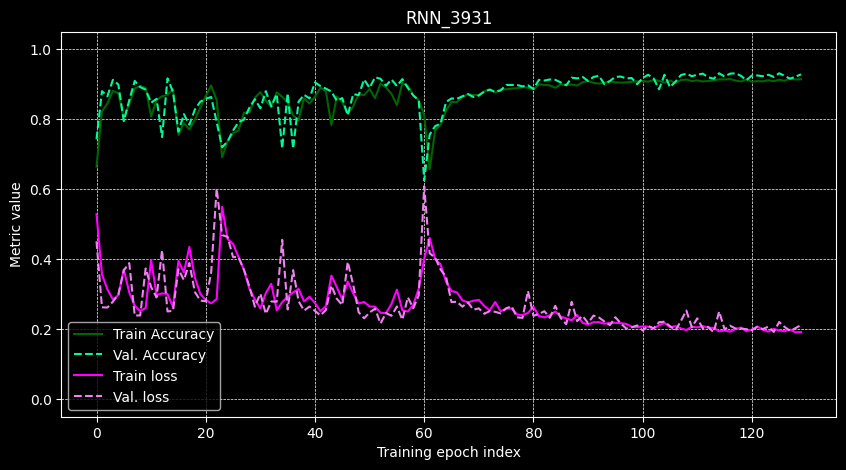

In [12]:
print(model.summary())
print()

# Print the model's results on testing data.
print(f"{model.name} results:")
for i, metric in enumerate(["Loss", "Accuracy", "Recall", "Precision"]):
    print(f"  {metric:>9s}: {results[i]:>5.3f}")


fig = plt.figure(figsize=(10,5))
fig.tight_layout()
ax = fig.add_subplot(111)


# Plot the binary accuracy and loss over training epochs.
ax.plot(history.epoch, history.history["binary_accuracy"], label="Train Accuracy", color='darkgreen', linestyle='-')
ax.plot(history.epoch, history.history["val_binary_accuracy"], label="Val. Accuracy", color='mediumspringgreen', linestyle='--')

ax.plot(history.epoch, history.history["loss"], label="Train loss", color='magenta', linestyle='-')
ax.plot(history.epoch, history.history["val_loss"], label="Val. loss", color='violet', linestyle='--')

ax.grid(which='both', linestyle='--', linewidth=0.5)

ax.set_ylim(-0.05, 1.05)
ax.legend()
ax.set_xlabel("Training epoch index")
ax.set_ylabel("Metric value")
ax.set_title(f"{model.name}")
plt.show()

#

In [13]:
# Save the model
# model.save('RNN_3931.keras')


In [14]:
# Load all filtered light curves for this field.

aperture = "opt" # Aperture size. Options: [opt, 066, 150, 500]

if os.path.isfile(f"lc_pkl/lc_{aperture}.pkl"):
    print(f"Loading existing file: lc_pkl/lc_{aperture}.pkl")
    with open(f"lc_pkl/lc_{aperture}.pkl", 'rb') as pfile:
        pkl_obj = pickle.load(pfile)
    all_lc = pkl_obj["all_lc"]
    useful_ids = pkl_obj["useful_ids"]
    assert all_lc.shape[0] == len(useful_ids), "Number of input light curves does not match the number of input source_id!"
    print(f"    Loaded {len(useful_ids)} light curves with total shape {all_lc.shape}.")
    
else:
    all_lc = []
    useful_ids = []
    
    all_ids = list(pd.unique(lc_df["source_id"]))
    
    np.random.shuffle(all_ids)
    
    skip_count = 0
    print(f"Formatting all {len(all_ids)} light curves.")
    for i,id in enumerate(all_ids):
        if i%int(0.1*len(all_ids)) == 0:
            print(f'  Progress: {i/len(all_ids)*100:5.1f}%   {datetime.now().strftime("%H:%M:%S")}')
        try:
            data = lc_df[lc_df["source_id"]==id][["mjd", f"mag_{aperture}", "filter"]]
            if len(data[data["filter"]=="q"]) < len(times_q)/2 or len(data[data["filter"]=="i"]) < len(times_i)/2 :
                skip_count += 1
                continue
            formatted_lc = format_lc(data, times, f"mag_{aperture}")
            all_lc.append(formatted_lc)
            useful_ids.append(id)
        except Exception as err:
            print(f"{id} failed:  {err}")
            continue
    
    all_lc = np.array(all_lc)
    
    print(f"Skipped {skip_count} light curves.\n")
    
    useful_ids = np.array(useful_ids) 
    print(f"Input data shape: {all_lc.shape}")
    print(f"Total unique source_id in all_ids: {len(useful_ids)}")
    assert all_lc.shape[0] == len(useful_ids), "Number of input light curves does not match the number of input source_id!"
        
    pickle_obj = {"useful_ids":useful_ids, "all_lc":all_lc}
    with open(f'lc_pkl/lc_{aperture}.pkl', "wb") as pfile: 
        pickle.dump(pickle_obj, pfile) 

#

Formatting all 107591 light curves.
  Progress:   0.0%   12:41:00
  Progress:  10.0%   12:43:26
  Progress:  20.0%   12:45:52
  Progress:  30.0%   12:48:17
  Progress:  40.0%   12:50:46
  Progress:  50.0%   12:53:17
  Progress:  60.0%   12:55:45
  Progress:  70.0%   12:58:14
  Progress:  80.0%   13:00:44
  Progress:  90.0%   13:03:13
  Progress: 100.0%   13:05:41
Skipped 3427 light curves.

Input data shape: (104164, 233)
Total unique source_id in all_ids: 104164


In [15]:
# Use our model to make predictions on all of the light curves.
predictions = model.predict(all_lc)

# Combine object "source_id" and its predicted "label" into a Pandas DataFrame.
predictions_df0 = pd.DataFrame({"SOURCE_ID":useful_ids, "label":predictions.reshape(1,-1)[0]})

# Merge the predicted labels DataFrame with the catalog DataFrame (from our red_cat.fits file) to obtain X_POS and Y_POS for each label 
predictions_df = predictions_df0.merge(catalog_df, on="SOURCE_ID")

#

3256/3256 [==============================] - 18s 6ms/step


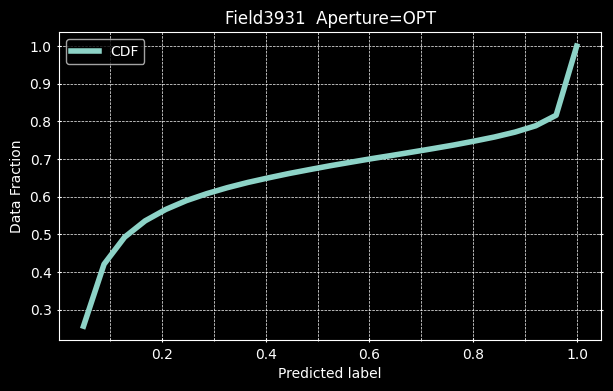

In [17]:
# Create a cumulative distribution function over the predicted labels.


from matplotlib.ticker import AutoMinorLocator, MultipleLocator

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

count, bins_count = np.histogram(list(predictions_df["label"].values), bins=25) 
cdf = np.cumsum(count/sum(count))

aps = {"opt":"OPT", "150":"1.5xFWHM", "066":"0.66xFWHM", "500":"5xFWHM"}
ax.plot(bins_count[1:], cdf, label="CDF", linewidth=4)
ax.set_title(f"Field3931  Aperture={aps[aperture]}")
ax.set_ylabel("Data Fraction")
ax.set_xlabel("Predicted label")
ax.tick_params(left=True, right=True, direction="inout", which="both")
ax.grid(color="white", linewidth=0.5, linestyle='--', which="both")
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend()
plt.savefig(f"Field3931_CDF_{aperture}.jpg", dpi=100)
plt.show()

#

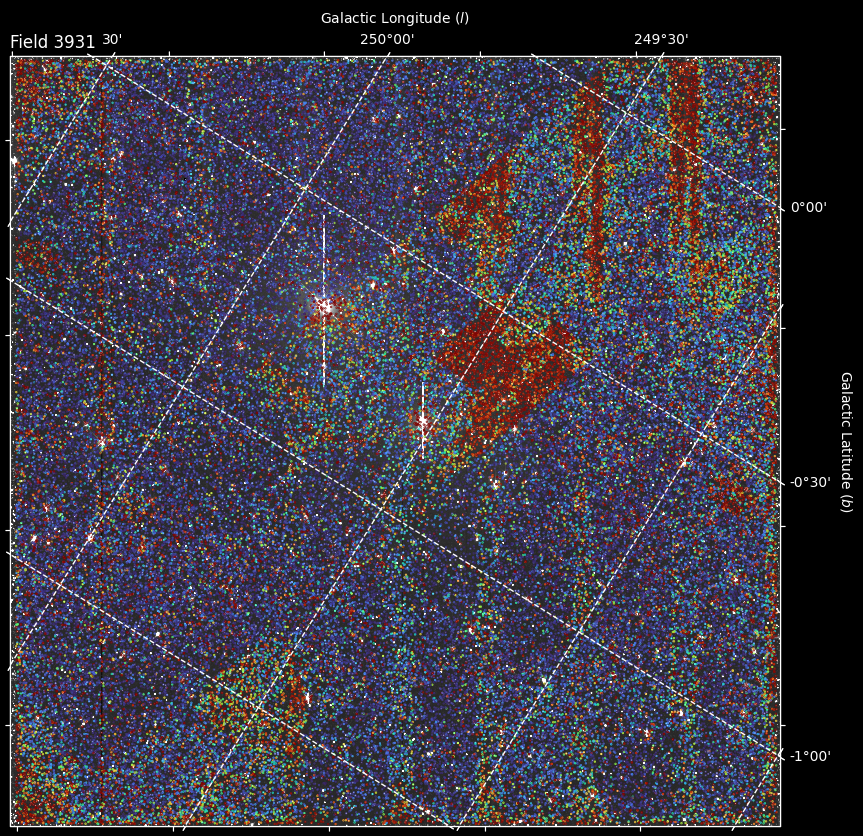

In [18]:
# Plot the predictions on an image of the field.

plot_ccd(predictions_df, image_file, 95, True)

#